In [1]:
import os
import os.path as osp

from datetime import datetime
import time
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from torch_geometric.data import Data
import torch_geometric
import networkx as nx


from sklearn.model_selection import train_test_split
import joblib

from ClusterDataset import ClusterDataset as GNNDataset
from ClusterDatasetTransformer import ClusterDataset
from train_transformer import *
from data_statistics import *
from GNN_TrackLinkingNet import EarlyStopping

from IPython.display import display

from Transformer import Transformer
from lang import Lang
from LossFunction import Loss

2025-06-02 13:53:00.826706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 13:53:00.848683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748865180.874302    1370 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748865180.881957    1370 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 13:53:00.909248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
input_length = 60
max_seq_length = 60
batch_size = 64
converter = Lang(0)

In [11]:
# Load the dataset
model_folder = "/eos/user/c/czeh/"
hist_folder = "/eos/user/c/czeh/histo_10pion0PU/"
data_folder_training = "/eos/user/c/czeh/graph_data/processed"
store_folder_training = "/eos/user/c/czeh/graph_data_trans"
data_folder_test = "/eos/user/c/czeh/graph_data_test/processed"
store_folder_test = "/eos/user/c/czeh/graph_data_trans_test"

scaler = joblib.load("/eos/user/c/czeh/graph_data/scaler.joblib")
scale = torch.tensor(scaler.scale_).to(device)

dataset_training = ClusterDataset(store_folder_training, data_folder_training, input_length=input_length, scaler=scale, output_group=False)
dataset_test = ClusterDataset(store_folder_test, data_folder_test, input_length=input_length, scaler=scale, output_group=False)

Done
Done


In [12]:
train_dl = DataLoader(dataset_training, shuffle=True, batch_size=batch_size)
test_dl = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)

In [13]:
epochs = 100
num_heads = 4
num_layers = 8
d_model = 128
d_ff = 256
dropout = 0.2
padding = converter.word2index["<PAD>"]
feature_num = len(dataset_test.model_feature_keys)
max_nodes = max(dataset_test.max_nodes, dataset_training.max_nodes)
vocab_size = max_nodes + 4


# Model, loss, and optimizer
model = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
criterion = Loss(converter)
max_nodes

166

In [14]:
# Optionally introduce weight decay
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# Drop Step Size over time
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
early_stopping = EarlyStopping(patience=5, delta=-0.02)

In [15]:
#Load Weights if needed
# weights = torch.load("/eos/user/c/czeh/tranformer_2.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

In [16]:
train_loss_hist = []
val_loss_hist = []

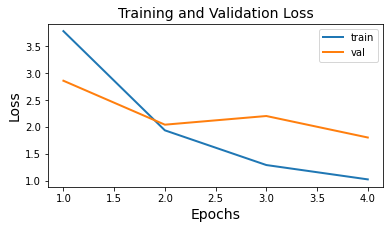

Epoch: 1


Training Epoch 1: 100%|██████████| 57/57 [00:41<00:00,  1.39it/s]


Training loss: 3.7855708515434934


Validation Epoch 1: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


Validation loss: 2.861910888126918
Epoch 2, LR: 0.0001
Epoch: 2


Training Epoch 2: 100%|██████████| 57/57 [00:24<00:00,  2.33it/s]


Training loss: 1.9381596310096874


Validation Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


Validation loss: 2.0433910063334872
Epoch 3, LR: 0.0001
Epoch: 3


Training Epoch 3: 100%|██████████| 57/57 [00:23<00:00,  2.47it/s]


Training loss: 1.291859229405721


Validation Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Validation loss: 1.7091048104422433
Epoch 4, LR: 0.0001
Epoch: 4


Training Epoch 4: 100%|██████████| 57/57 [00:23<00:00,  2.39it/s]


Training loss: 1.024598479270935


Validation Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


Validation loss: 1.6610233272824968


In [ ]:
# https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
# Optionally introduce gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25)

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

display_loss = display(1, display_id=True)

optimizer.zero_grad()

# Training loop
for epoch in range(1, 101):
    print(f'Epoch: {epoch}')
    
    loss = train(model, optimizer, train_dl, epoch, criterion, vocab_size, device=device)
    print(f"Training loss: {loss}")
    train_loss_hist.append(loss)
    
    val_loss = test(model, test_dl, epoch, criterion, vocab_size, device=device)
    val_loss_hist.append(val_loss)
    print(f"Validation loss: {val_loss}")
    
    ax_loss.clear()
    plot_loss(train_loss_hist, val_loss_hist, ax=ax_loss, n=1)
    display_loss.update(fig_loss)
    time.sleep(1)
    
    scheduler.step()
    print(f"Epoch {epoch+1}, LR: {scheduler.get_last_lr()[0]}")
    
    early_stopping(model, val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping after {epoch+1} epochs")
        early_stopping.load_best_model(model)
        break

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(10)
epochs = len(train_loss_hist)
ax.plot(range(1, epochs+1), moving_average(train_loss_hist, 8), label='train', linewidth=2)
ax.plot(range(1, epochs+1), moving_average(val_loss_hist, 8), label='val', linewidth=2)
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)
ax.set_title("Training and Validation Loss", fontsize=14)
ax.legend()

In [ ]:
date = f"{datetime.now():%Y-%m-%d-%h}"
save_model(model, epoch, optimizer, train_loss_hist, val_loss_hist, model_folder, f"tranformer_date_{date}.pt")

## Test Full Event

In [ ]:
from EventGrouping import EventGrouping

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
weights = torch.load("/eos/user/c/czeh/tranformer_date_2025-05-30.pt", weights_only=True)
model.load_state_dict(weights["model_state_dict"])

In [ ]:
components = dataset_test.get(0)
print(len(components))

In [ ]:
runner = EventGrouping(model, seq_length=input_length)


nTrackster = 0
for component in components:
    max_comp_t = int(torch.max(component["x"]).item())
    if max_comp_t > nTrackster:
        nTrackster = max_comp_t
  
group = 0
edges = np.full(nTrackster, -1)

    
for component in components:
    res = runner(component)[-1]
    print(res)
    converter = Lang(trackster_list=component["lang"])
    new_groups = converter.seq2y(res.cpu().numpy(), nodes=nTrackster, start_group=group)
    print(np.array(range(new_groups.shape[0]))[new_groups >= 0])
    edges = np.maximum(edges, converter.seq2y(res.cpu().numpy(), nodes=nTrackster, start_group=group))
    print(np.max(edges))
    group = np.max(edges) + 1

In [ ]:
edges[edges>=0]

## Random Tests

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
weights = torch.load("/eos/user/c/czeh/tranformer_date_2025-05-30.pt", weights_only=True)
model.load_state_dict(weights["model_state_dict"])

In [ ]:
components = dataset_test.get(0)
components[0]["lang"]

In [ ]:
vocab_size

In [ ]:
num_nodes = components[0]["nTrackster"]
converter = Lang(trackster_list=components[0]["lang"])
sample_seq = converter.starting_seq(components[0]["root"], input_length).to(device)
print(sample_seq)

X = components[0]["x"].float()
X = F.pad(X, pad=(0, 0, max_nodes - num_nodes, 0), value=converter.word2index["<PAD>"])
X = X[:, list(map(dataset_test.node_feature_dict.get, dataset_test.model_feature_keys))]

predictions = model(torch.unsqueeze(X, dim=0), torch.unsqueeze(sample_seq, dim=0))
torch.argsort(predictions[0, -1, :num_nodes], dim=0)[0].item()

In [ ]:
targets[targets[:, -1] != -4, :]

In [ ]:
targets[mask].shape[0]/3

In [ ]:
opts = dataset_training.__getitem__(0)[1]
opts = torch.roll(opts, -1, dims=0)
opts[-1] = 5
opts

In [ ]:
out_mask = opts != -4
opts[out_mask].shape[0]

In [ ]:
targets = torch.reshape(targets[mask], (int(targets[mask].shape[0]/3), 3))

In [ ]:
targets[0, :]